# Computer Exercise 1 in Image Proccessing

## By Yair Nadler


In [69]:
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import numpy as np
import cv2 as cv
import sys

### Part 1 - Histogram Manipulation


#### ploting the transformation of the gray levels


In [70]:
def plot_gray_levels_transformation(transformed_gray_levels, title, x_label="Gray Level", y_label="New Gray Level"):
    gray_levels = np.arange(0, 256)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    fig.tight_layout()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid()

    #plot each gray level transformation
    for t in transformed_gray_levels:
        ax.plot(gray_levels, t)

#### The needed methods the perform the power law transformation


In [71]:

def normalize(gray_levels):
    # normalize gray_levels
    maxGray = np.max(gray_levels)
    minGray = np.min(gray_levels)
    return (gray_levels - minGray) / (maxGray - minGray)

def denormalize(gray_levels, maxGray=255, minGray=0):
    # denormalize gray_levels
    return (gray_levels * (maxGray - minGray)) + minGray

def power_law_transformation(gamma, c, r):
    # normalize r
    normalized_r = normalize(r)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    fig.tight_layout()
    ax.set_title('Power Law Transformation')
    ax.set_xlabel('Input Gray Level')
    ax.set_ylabel('Output Gray Level')
    ax.grid()
    for g in gamma:
        s = c * np.power(normalized_r, g)
        s = denormalize(s)
        ax.plot(r, s, label='gamma = {}'.format(g))
    ax.legend(gamma)
    plt.show()


#### Performing the power law transformation with the given exercise example


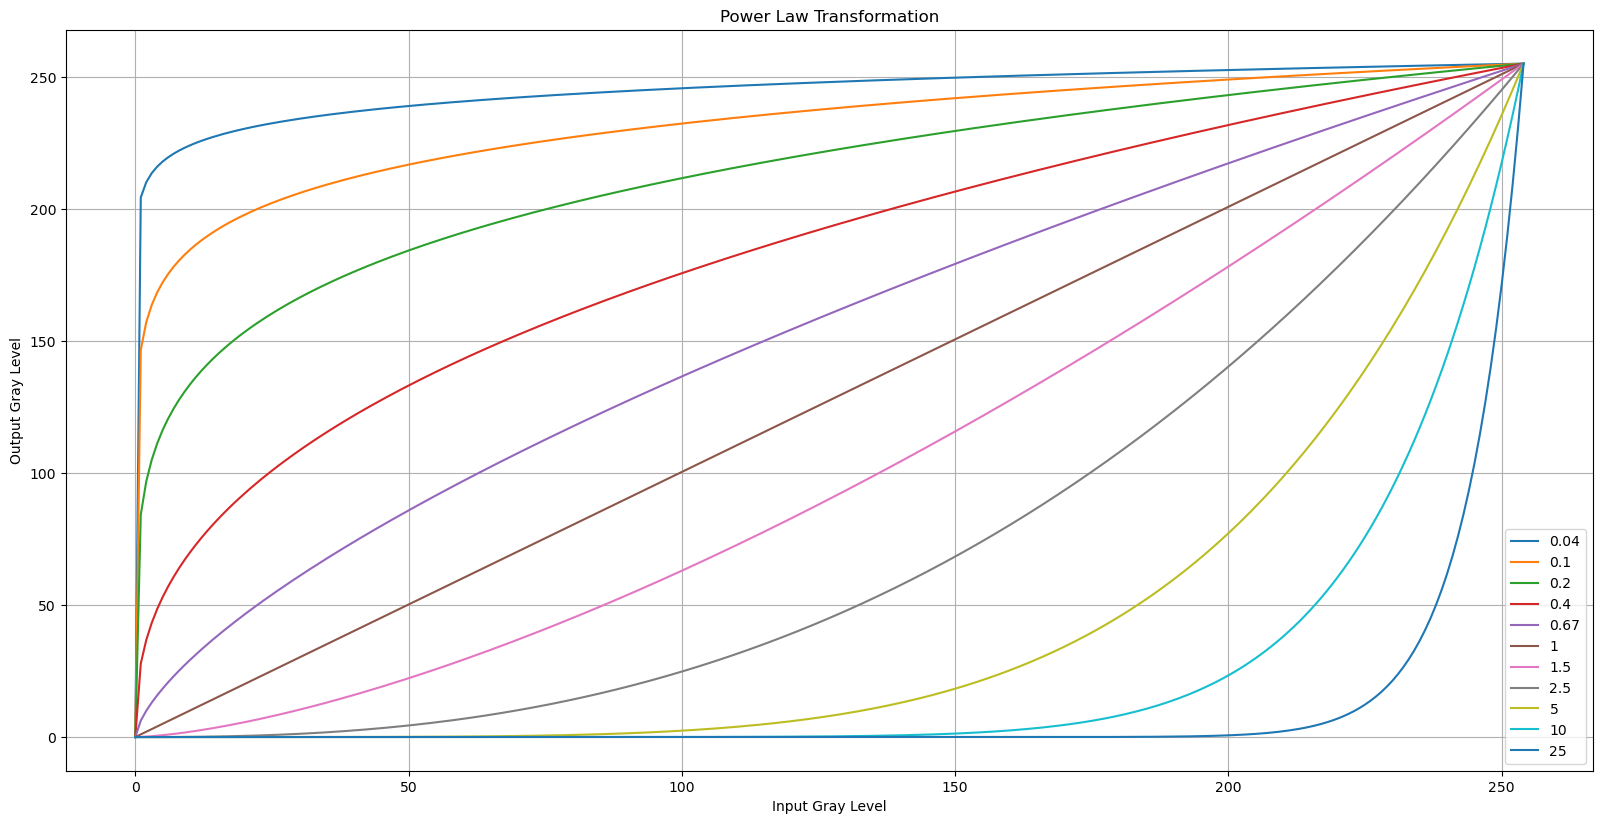

In [72]:

gamma = [0.04, 0.1, 0.2, 0.4, 0.67, 1, 1.5, 2.5, 5, 10, 25]
c = 1
r = np.arange(0, 255)
power_law_transformation(gamma, c, r)

#### Loading the mri_spine.jpg image and showing its histogram


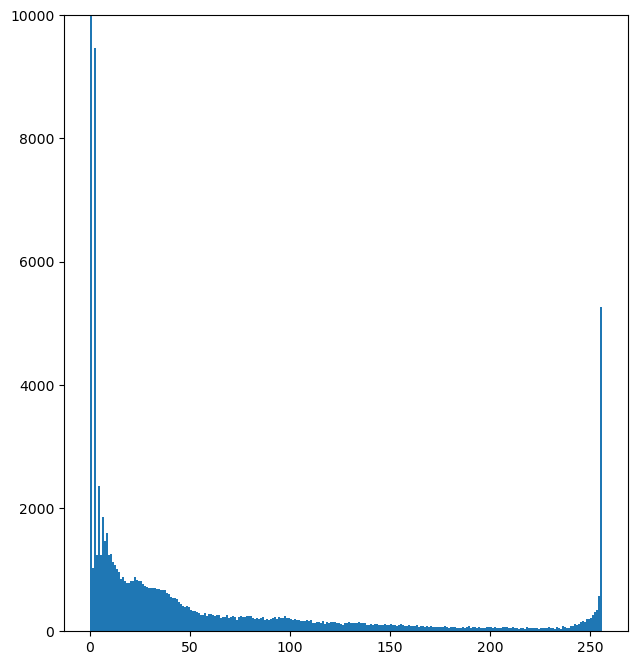

In [73]:
#load mri_spine.jpg
mri_img = cv.imread("../mri_spine.jpg", 0)
#show the image's histogram
plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 2, 1)
ax.set_ylim([0, 10000])
plt.hist(mri_img.ravel(), 256, [0, 256])
plt.show()


#### Building LUT


In [74]:

def build_LUT(gamma, c=1):
    gray_levels = np.arange(0, 256)
    gray_levels = normalize(gray_levels)
    s = c * np.power(gray_levels, gamma)
    s = denormalize(s)
    return s.astype(np.uint8)



#### Applying the LUT changes with explicit gamma and c


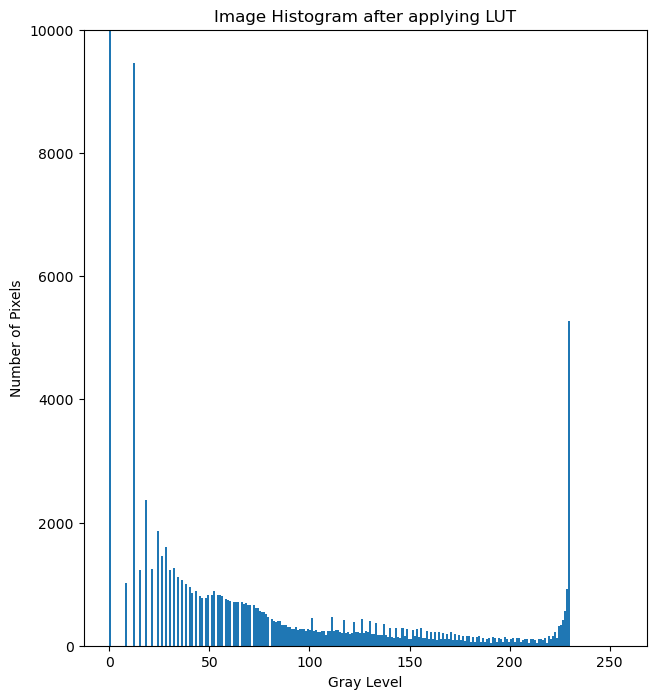

In [84]:
lut = build_LUT(0.6, 0.9)
# apply LUT
res = cv.LUT(mri_img, lut)

# show the image's histogram
plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 2, 1)
ax.set_ylim([0, 10000])
ax.set_title('Image Histogram after applying LUT')
ax.set_xlabel('Gray Level')
ax.set_ylabel('Number of Pixels')
plt.hist(res.ravel(), 256, [0, 256])
plt.show()

#### Show the original image and the new image using openCV


In [81]:
cv.imshow('Original Image', mri_img)
cv.imshow('New Image', res)
cv.waitKey(0)
cv.destroyAllWindows()

#### The next block of codes are used to perform the histogram euqalization based on a given threshold list corresponding to the amount of the explicitly stated number of regions.

#### Before each selection press the 's' key on the keyboard and enter when done with the selection. When done selecting press the 'q' button (Make sure your keyboard is set to english). To get a simple histogram equalization set to choose 1 area and choose the entire image.

In [88]:
# for each ROI, equalize the histogram of the image according to the correspinding threshold in the T list
def equalize_histogram_per_selected_area(img, rois, T):
    # create a copy of the image
    res = img.copy()
    # for each ROI, equalize the histogram of the image according to the correspinding threshold in the T list
    for i in range(len(rois)):
        roi = rois[i]
        x, y, w, h = roi
        # equalize the histogram of the image according to the correspinding threshold in the T list
        res[y:y+h, x:x+w] = cv.equalizeHist(res[y:y+h, x:x+w])
        # apply thresholding by returning all the values less than T[i] to their original value
        for j in range(y, y+h):
            for k in range(x, x+w):
                if res[j, k] < T[i]:
                    res[j, k] = img[j, k]
    return res


In [89]:
def customized_histogram_equalization(img, T = -1):
    # Create a list to store the ROIs
    rois = []
    
    # Create a copy of the image to draw the ROIs on
    image_with_rois = img.copy()

    # Show the image and wait for the user to select a ROI
    while True:
        cv.imshow((f"{len(rois)}/{len(T)} areas selected"), image_with_rois)
        key = cv.waitKey(1) & 0xFF

        # Break the loop if the user presses 'q'
        if key == ord('q'):
            break

        # Wait for the user to select a ROI
        elif key == ord('s'):
            roi = cv.selectROI((f"{len(rois)}/{len(T)} areas selected"), image_with_rois, fromCenter=False, showCrosshair=True)

            # Add the ROI to the list if it has a non-zero area
            if roi[2] > 0 and roi[3] > 0:
                rois.append(roi)
                
            # Show the selected ROIs
            for roi in rois:
                x, y, w, h = roi
                cv.rectangle(image_with_rois, (x, y), (x + w, y + h), (255, 255, 0), 2)

    # Release resources
    cv.destroyAllWindows()
    
    customized_histogram_img = equalize_histogram_per_selected_area(img, rois, T)
    return customized_histogram_img

##### Run this block of code with the explicit selected number of regions. The default thershold value for each area of interest is -1.


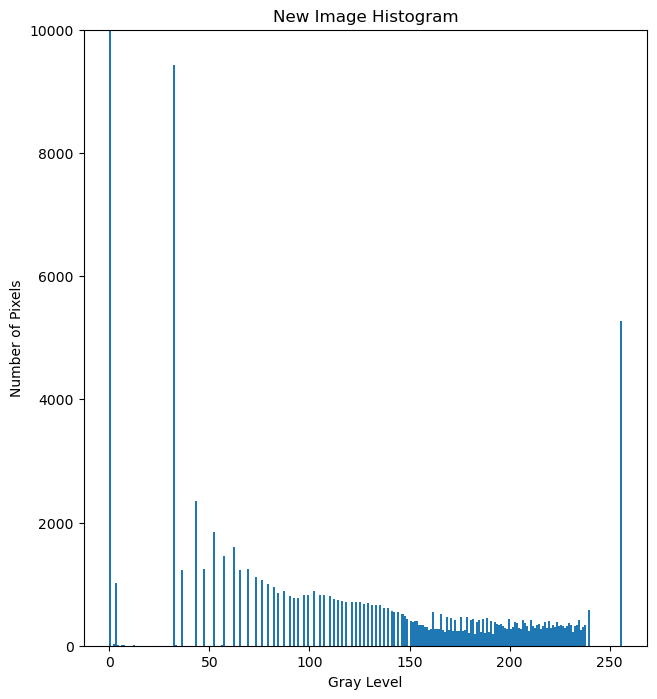

In [91]:
number_of_region_of_interest = 5
default_threshold = [-1 for i in range(number_of_region_of_interest)]
customized_histogram_img = customized_histogram_equalization(mri_img, default_threshold)

#show the original image and the new image using openCV
cv.imshow('Original Image', mri_img)
cv.imshow('Selected Equalized Histogram', customized_histogram_img)
cv.waitKey(0)
cv.destroyAllWindows()

# show the new histogram
plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 2, 1)
ax.set_ylim([0, 10000])
ax.set_title('New Image Histogram')
ax.set_xlabel('Gray Level')
ax.set_ylabel('Number of Pixels')
plt.hist(customized_histogram_img.ravel(), 256, [0, 256])
plt.show()

### Part 2 - Frequencie in Images

#### Loading the Uma.jpg image and showing it together with its 2D furier transformation

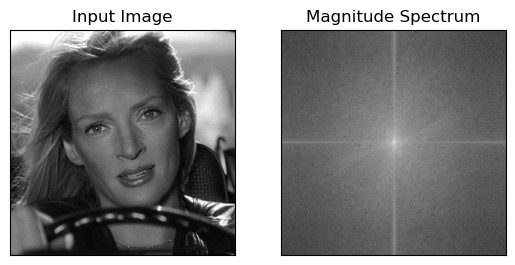

In [34]:
uma_img = cv.imread('../uma.jpg', 0)

# Compute the 2D Fourier transform of the image
def compute_fourier_transformation(img):
    dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    amplitude = 20 * np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
    return amplitude, dft_shift

def show_fourier_transformation(img):
    f, _ = compute_fourier_transformation(img)
    plt.subplot(121), plt.imshow(uma_img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(f, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

show_fourier_transformation(uma_img)

#### Choose lowest 5% frequencies in both X and Y axis

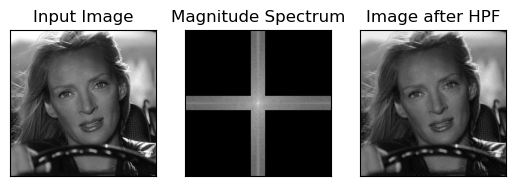

In [76]:
amplitude, dft_shift = compute_fourier_transformation(uma_img)

# divide the magnitude spectrum to X and Y axis
rows, cols = uma_img.shape

# create a mask first, 5% around each axis is 1, remaining all zeros
mask = np.zeros((rows, cols, 2), np.uint8)
center_row, center_col = rows//2 , cols//2 
row_five_percent = int(rows * 0.05)
col_five_percent = int(cols * 0.05)
mask[center_row - row_five_percent : center_row + row_five_percent, 0 : cols] = 1
mask[0 : rows, center_col-col_five_percent : center_col + col_five_percent] = 1

# apply mask and inverse DFT
fshift = dft_shift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])


# Display the original image, the mask on the magnitude spectrum and the filtered image
plt.subplot(131), plt.imshow(uma_img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(amplitude * mask[:,:,0], cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_back, cmap='gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.show()

#### Sum values of the columns and the rows in the resulting amplitude and choose the top 5%

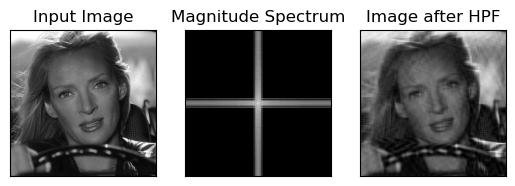

In [120]:
amplitude, dft_shift = compute_fourier_transformation(uma_img)

# Sum the values of the columns and rows in the amplitude spectrum
col_sum = np.sum(amplitude, axis=0)
row_sum = np.sum(amplitude, axis=1)

# get the indices of the 5% highest values of the columns and rows in the amplitude spectrum
x_indices = np.argsort(row_sum)[-int(rows * 0.05):]
y_indices = np.argsort(col_sum)[-int(cols * 0.05):]

# create a mask
mask = np.zeros((rows, cols, 2), np.uint8)
mask[x_indices, :, :] = 1
mask[:, y_indices, :] = 1

# apply mask and inverse DFT
fshift = dft_shift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])

# save the masked amplitude spectrum
# cv.imwrite('amplitude_spectrum.jpg', amplitude * mask[:,:,0])

# Display the original image, the mask on the magnitude spectrum and the filtered image
plt.subplot(131), plt.imshow(uma_img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(amplitude * mask[:,:,0], cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_back, cmap='gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.show()

#### Finding the most dominant 10% 2D frequencies in the image

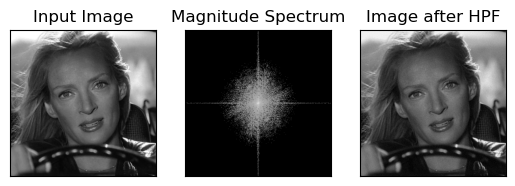

In [122]:
# Compute the 2D Fourier transform of the image
amplitude, dft_shift = compute_fourier_transformation(uma_img)

# Calculate the most dominant 10% of the amplitude spectrum
threshold = np.percentile(amplitude, 90)

# Create a mask
mask = np.zeros((rows, cols, 2), np.uint8)
mask[amplitude >= threshold] = 1

# Apply mask and inverse DFT
fshift = dft_shift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])

# save the masked amplitude spectrum
cv.imwrite('amplitude_spectrum_2.jpg', amplitude * mask[:,:,0])

# Display the original image, the mask on the magnitude spectrum and the filtered image
plt.subplot(131), plt.imshow(uma_img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(amplitude * mask[:,:,0], cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_back, cmap='gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.show()

### Part 3 - Movment And Rotating in Place

#### Moving an image

##### Implementing the fiven g(x, y) formula

In [19]:
def g(img, x, y, dx, dy):
    # pad image with zeros
    img = np.pad(img, ((1, 1), (1, 1)), 'constant')
    i1j1 = img[x, y] if img[x , y] else 0
    i1j2 = img [x + 1, y] if img[x + 1, y] else 0
    i2j1 = img[x, y + 1] if img[x, y + 1] else 0
    i2j2 = img[x + 1, y + 1] if img[x + 1, y + 1] else 0
    return (1 - dx) * (1 - dy) * i1j1 + dx * (1 - dy) * i1j2 + (1 - dx) * dy * i2j1 + dx * dy * i2j2

##### Moving the image where dx and dy are known to be in the range [0, 1)

In [20]:
# perform bilinear interpolation. Moves the image by (dx,dy) where dx, dy are known to be in [0,1)
def bilinear_interpolation(img, dx, dy):
    rows, cols = img.shape
    for x in range(rows):
        for y in range(cols):
            img[x, y] = g(img, x, y, dx, dy)
    return img

##### Generalized move method where dx and dy can be any real numbers

In [30]:
# perform moving in [dx,dy] using bilnear interpolation. dx, dy can be any real numbers
def generalized_move(img, dx, dy):
    # get the fraction and integer part of dx and dy
    dx_fraction, dx_integer = dx - int(dx), int(dx)
    dy_fraction, dy_integer = dy - int(dy), int(dy)

    # perform bilinear interpolation
    moved_image = bilinear_interpolation(img, dx_fraction, dy_fraction)

    # create new image of size (img.shape[0] + |dx|, img.shape[1] + |dy|)
    new_img = np.zeros((img.shape[0] + abs(dx_integer), img.shape[1] + abs(dy_integer)))

    # copy the original image to the new image
    if dx > 0 and dy > 0:
        new_img[dx_integer : dx_integer + img.shape[0], dy_integer : dy_integer + img.shape[1]] = moved_image
    elif dx > 0 and dy < 0:
        new_img[dx_integer : dx_integer + img.shape[0], : img.shape[1]] = moved_image
    elif dx < 0 and dy > 0:
        new_img[: img.shape[0], dy_integer : dy_integer + img.shape[1]] = moved_image
    else:
        new_img[: img.shape[0], : img.shape[1]] = moved_image

    return new_img

##### Performing the movment on camerman.jpg

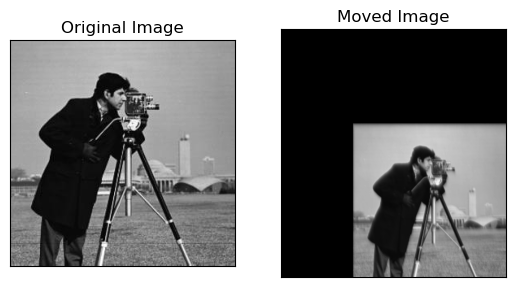

In [31]:
# load cameraman image
cameraman_img = cv.imread('../cameraman.jpg', 0)
moved_img = cameraman_img.copy()

# transform the image to gray scale in the range [0,1]
moved_img = moved_img / 255

# move the image by (170.3, 130.8)
moved_img = generalized_move(moved_img, 170.3, 130.8)

# show the original image and the moved image
plt.subplot(121), plt.imshow(cameraman_img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(moved_img, cmap='gray')
plt.title('Moved Image'), plt.xticks([]), plt.yticks([])
plt.show()

#### Rotating an image

##### Loading brad.jpg image

In [23]:
brad_img = cv.imread('../Brad.jpg', 0)

##### Creating the mask

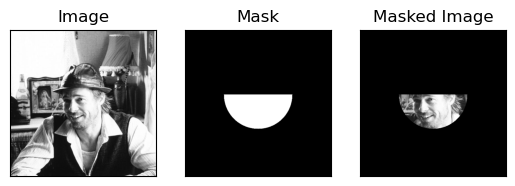

In [43]:
# creating a mask that is a downwards semi-circle around brad's face
mask1 = np.zeros(brad_img.shape, np.uint8)
mask1 = cv.circle(mask1, (int(brad_img.shape[1] / 2), int(brad_img.shape[0] / 2) - 30), 120, (255, 255, 255), -1)

# blacken the top half of the mask
mask1[: int(brad_img.shape[0] / 2) - 30, :] = 0

# apply mask to brad's image
brad_win = cv.bitwise_and(brad_img, brad_img, mask=mask1)

# show the image, the mask and the masked image
plt.subplot(131), plt.imshow(brad_img, cmap='gray')
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(mask1, cmap='gray')
plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(brad_win, cmap='gray')
plt.title('Masked Image'), plt.xticks([]), plt.yticks([])
plt.show()

##### Rotating the image around its center with a given degree alpha. If bilinear interpolation is true than the method will perform bilnear transformation while rotating

In [65]:
# the following method recieves an image and rotates it by alpha degrees around the center of the image
def rotate_image(img, alpha, bilinear_interpolation = False):
    # convert alpha to radians
    alpha_in_radians = np.deg2rad(alpha)

    # get new image size
    new_height = int(img.shape[0] * abs(np.cos(alpha_in_radians)) + img.shape[1] * abs(np.sin(alpha_in_radians)))
    new_width = int(img.shape[0] * abs(np.sin(alpha_in_radians)) + img.shape[1] * abs(np.cos(alpha_in_radians)))

    # create new image of size (new_height, new_width)
    rotated_image = np.zeros((new_height, new_width))

    # get the center of the new image
    new_center = (int(new_width / 2), int(new_height / 2))

    # get the center of the original image
    center = (int(img.shape[1] / 2), int(img.shape[0] / 2))

    # rotate the image around the center
    for x in range(new_height):
        for y in range(new_width):
            # get the new coordinates
            new_x = (x - new_center[0]) * np.cos(alpha_in_radians) + (y - new_center[1]) * np.sin(alpha_in_radians) + center[0]
            new_y = -(x - new_center[0]) * np.sin(alpha_in_radians) + (y - new_center[1]) * np.cos(alpha_in_radians) + center[1]

            # round the coordinates
            new_x = round(new_x)
            new_y = round(new_y)

            # check if the new coordinates are in the original image
            if 0 <= new_x < img.shape[0] and 0 <= new_y < img.shape[1]:
                if bilinear_interpolation:
                    rotated_image[x, y] = g(img, int(new_x), int(new_y), new_x - int(new_x), new_y - int(new_y))
                else:
                    rotated_image[x, y] = img[new_x, new_y]
                    
    return rotated_image

#### Apply on brad_win image

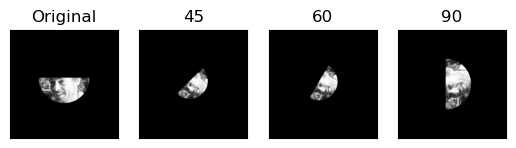

In [66]:
# rotate brad's image
rotated_brad_45 = rotate_image(brad_win, 45)
rotated_brad_60 = rotate_image(brad_win, 60)
rotated_brad_90 = rotate_image(brad_win, 90)

# show the original image and the rotated images
plt.subplot(141), plt.imshow(brad_win, cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(142), plt.imshow(rotated_brad_45, cmap='gray')
plt.title('45'), plt.xticks([]), plt.yticks([])
plt.subplot(143), plt.imshow(rotated_brad_60, cmap='gray')
plt.title('60'), plt.xticks([]), plt.yticks([])
plt.subplot(144), plt.imshow(rotated_brad_90, cmap='gray')
plt.title('90'), plt.xticks([]), plt.yticks([])
plt.show()

##### Rotating the image around the center while using bilnear interpolation

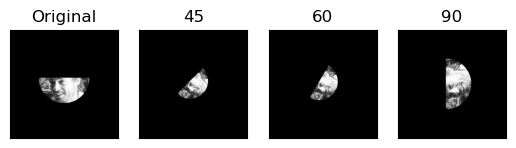

In [67]:
# rotate brad's image with bilinear
rotated_brad_45 = rotate_image(brad_win, 45, bilinear_interpolation=True)
rotated_brad_60 = rotate_image(brad_win, 60, bilinear_interpolation=True)
rotated_brad_90 = rotate_image(brad_win, 90, bilinear_interpolation=True)

# show the original image and the rotated images
plt.subplot(141), plt.imshow(brad_win, cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(142), plt.imshow(rotated_brad_45, cmap='gray')
plt.title('45'), plt.xticks([]), plt.yticks([])
plt.subplot(143), plt.imshow(rotated_brad_60, cmap='gray')
plt.title('60'), plt.xticks([]), plt.yticks([])
plt.subplot(144), plt.imshow(rotated_brad_90, cmap='gray')
plt.title('90'), plt.xticks([]), plt.yticks([])
plt.show()